# Image Search with Milvus

This notebook demonstrates how to perform image similarity search using Milvus vector database. It uses a pre-trained ResNet model to extract image features and stores them in Milvus for efficient similarity search.


In [1]:
# Import required libraries
import torch
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from pymilvus import MilvusClient
import os
from IPython.display import display


## Feature Extractor Class

This class handles the extraction of image features using a pre-trained model from the TIMM library.


In [2]:
class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()


## Milvus Setup

Connect to Milvus and create a collection for storing image embeddings.


In [3]:
# Connect to Milvus
client = MilvusClient(
    uri="http://localhost:19530",
    token="root:Milvus"
)

# Drop existing collection if it exists
if client.has_collection(collection_name="image_embeddings"):
    client.drop_collection(collection_name="image_embeddings")

# Create new collection
client.create_collection(
    collection_name="image_embeddings",
    vector_field_name="vector",
    dimension=512,
    auto_id=True,
    enable_dynamic_field=True,
    metric_type="COSINE",
)

print("Milvus collection 'image_embeddings' created successfully!")


Milvus collection 'image_embeddings' created successfully!


## Initialize Feature Extractor

Create an instance of the FeatureExtractor using ResNet34 model.


In [4]:
# Initialize the feature extractor with ResNet34
extractor = FeatureExtractor("resnet34")
print("Feature extractor initialized with ResNet34 model")


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Feature extractor initialized with ResNet34 model


## Data Ingestion

Process images from the training directory and insert their embeddings into Milvus.


In [5]:
# Process and insert images
root = "data/train"
insert = True

if insert is True:
    processed_count = 0
    for dirpath, foldername, filenames in os.walk(root):
        for filename in filenames:
            if filename.endswith(".JPEG"):
                filepath = dirpath + "/" + filename
                image_embedding = extractor(filepath)
                client.insert(
                    "image_embeddings",
                    {"vector": image_embedding, "filename": filepath},
                )
                processed_count += 1
                if processed_count % 100 == 0:
                    print(f"Processed {processed_count} images...")
    
    print(f"Total images processed: {processed_count}")
    print("Data ingestion completed!")


Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Total images processed: 1000
Data ingestion completed!


## Image Search

Perform similarity search using a query image and display the results.


In [6]:
# Define query image
query_image = "data/test/Afghan_hound/n02088094_4261.JPEG"

# Perform search
results = client.search(
    "image_embeddings",
    data=[extractor(query_image)],
    output_fields=["filename"],
    search_params={"metric_type": "COSINE"},
)

print("Search completed!")
print(f"Found {len(results[0])} similar images")


Search completed!
Found 10 similar images


## Display Results

Visualize the query image and the top similar images found by the search.


Query Image:


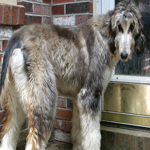


Top 10 Similar Images:


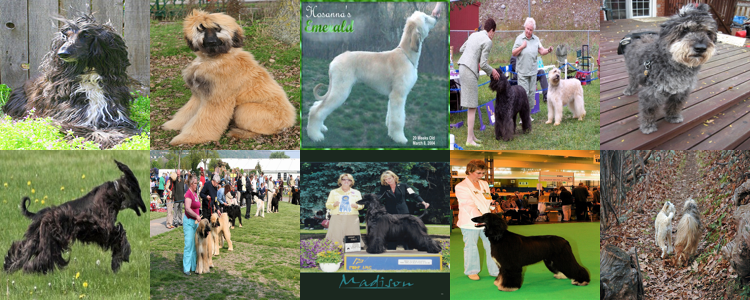

In [7]:
# Prepare images for display
images = []
for result in results:
    for hit in result[:10]:  # Get top 10 results
        filename = hit["entity"]["filename"]
        img = Image.open(filename)
        img = img.resize((150, 150))
        images.append(img)

# Create a grid of images
width = 150 * 5
height = 150 * 2
concatenated_image = Image.new("RGB", (width, height))

for idx, img in enumerate(images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 150, y * 150))

# Display the query image and results
print("Query Image:")
display(Image.open(query_image).resize((150, 150)))

print("\nTop 10 Similar Images:")
display(concatenated_image)
